In [ ]:
#pip install tensorflow

In [19]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
 
import urllib.request
 
import matplotlib.image as mpimg


In [74]:
PATH

'fruits-360_dataset/fruits-360'

In [2]:
PATH = os.getcwd()
PATH = 'fruits-360_dataset/fruits-360'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        fruits-360_dataset/fruits-360
PATH_Data:   fruits-360_dataset/fruits-360/Test
PATH_Result: fruits-360_dataset/fruits-360/Results


In [3]:
 spark = (SparkSession
             .builder
             .appName('p8_local')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

24/05/25 21:37:38 WARN Utils: Your hostname, ibugueye-HP-ProBook-450-G3 resolves to a loopback address: 127.0.1.1; using 192.168.1.198 instead (on interface wlp3s0)
24/05/25 21:37:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/25 21:37:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
sc = spark.sparkContext


In [5]:
spark


In [6]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------------------------------------------------------+----------+
|path                                                                                              |label     |
+--------------------------------------------------------------------------------------------------+----------+
|file:/home/ibugueye/Documents/projet_8/fruits-360_dataset/fruits-360/Test/Watermelon/r_106_100.jpg|Watermelon|
|file:/home/ibugueye/Documents/projet_8/fruits-360_dataset/fruits-360/Test/Watermelon/r_109_100.jpg|Watermelon|
|file:/home/ibugueye/Documents/projet_8/fruits-360_dataset/fruits-360/Test/Watermelon/r_108_100.jpg|Watermelon|
|file:/home/ibugueye/Documents/projet_8/fruits-360_dataset/fruits-360/Test/Watermelon/r_107_100.jpg|Watermelon|
|file:

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [10]:
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [11]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [86]:
#pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.L'exécution de cette cellule démarre l'application Spark

    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/ibugueye/.local/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [14]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

# Exemple de DataFrame Spark features_df
features_df = images.repartition(24).select(col("path"), col("label"), featurize_udf("content").alias("features"))

In [15]:
print(PATH_Result)

fruits-360_dataset/fruits-360/Results


In [16]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2024-05-25 21:39:44.325302: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 21:39:44.330201: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 21:39:44.390908: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 21:39:45.599914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 875m

In [17]:
features_df.show()

+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|file:/home/ibugue...|    Watermelon|[0.1886028, 0.350...|
|file:/home/ibugue...|    Watermelon|[0.12482208, 0.02...|
|file:/home/ibugue...|    Watermelon|[0.0, 0.40212354,...|
|file:/home/ibugue...|Pineapple Mini|[0.0, 4.5104876, ...|
|file:/home/ibugue...|Pineapple Mini|[0.0, 4.5876455, ...|
|file:/home/ibugue...|    Watermelon|[0.6159202, 0.622...|
|file:/home/ibugue...|Pineapple Mini|[0.0, 4.284006, 0...|
|file:/home/ibugue...|    Watermelon|[0.0, 0.7224134, ...|
|file:/home/ibugue...|Pineapple Mini|[0.0, 4.718264, 0...|
|file:/home/ibugue...|    Watermelon|[0.010367909, 0.1...|
|file:/home/ibugue...|    Watermelon|[0.006684965, 0.3...|
|file:/home/ibugue...|    Watermelon|[0.0, 0.2425789, ...|
|file:/home/ibugue...|   Cauliflower|[0.0, 0.3008667, ...|
|file:/home/ibugue...|   Cauliflower|[0.0, 1.3056875, ..

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


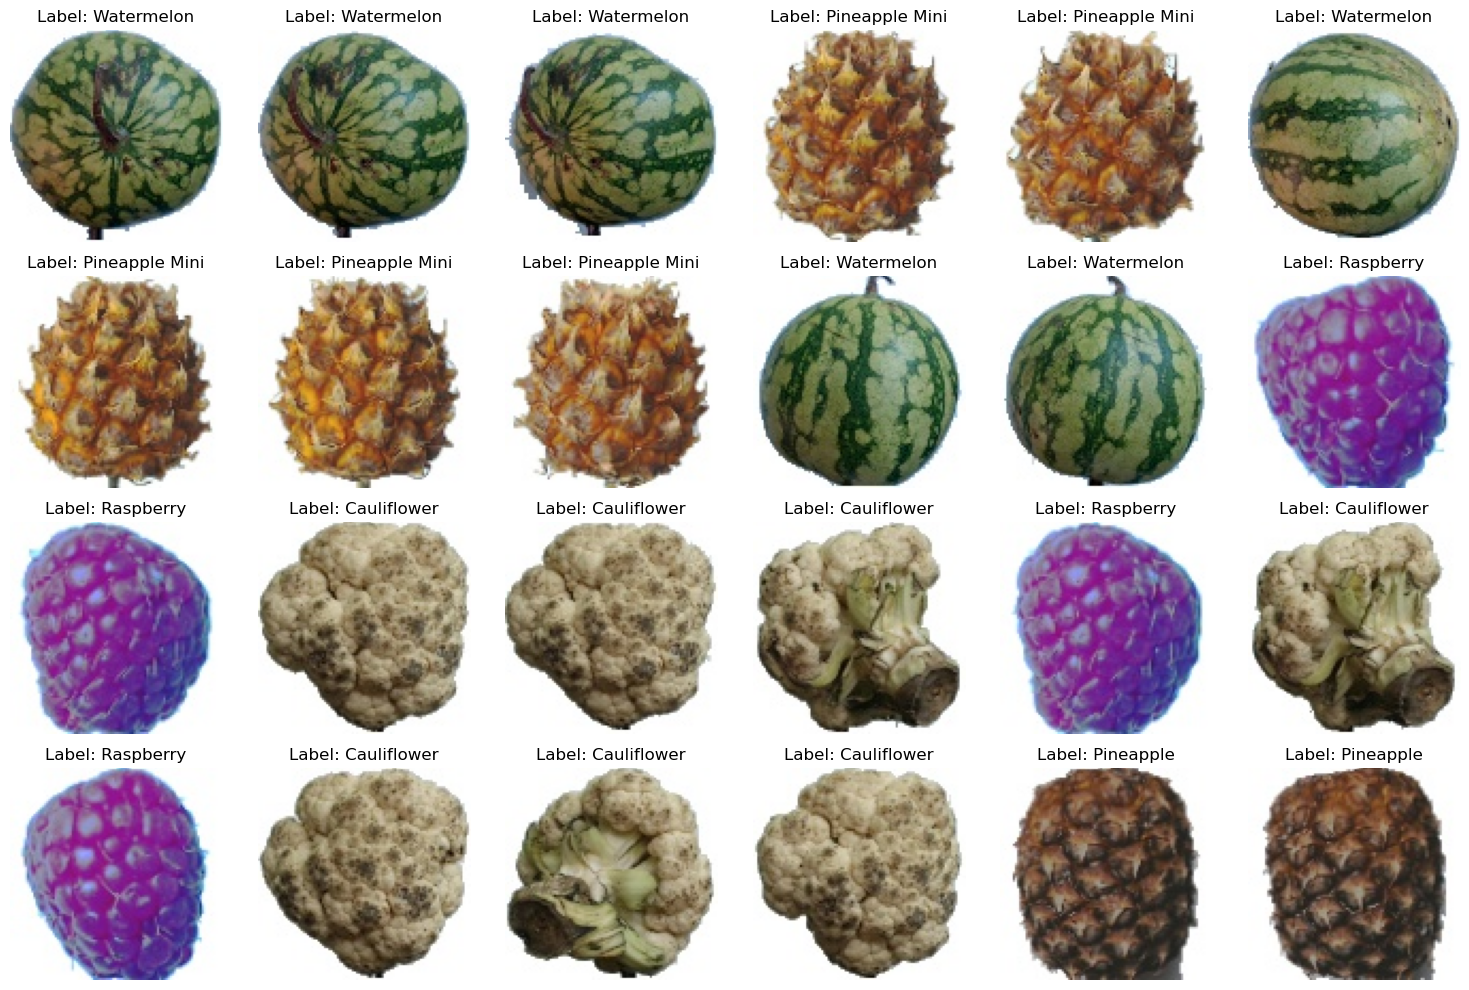

In [20]:

# Collecter les données nécessaires
data = features_df.select("path", "label").collect()

# Afficher les images avec matplotlib
fig, axes = plt.subplots(4, 6, figsize=(15, 10))
axes = axes.flatten()

for i, row in enumerate(data):
    if i >= 24:
        break
    try:
        # Ouvrir l'URL pour lecture et passer le résultat à Pillow
        with urllib.request.urlopen(row['path']) as url:
            img = np.array(Image.open(url))
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {row['label']}")
        axes[i].axis('off')
    except Exception as e:
        print(f"Erreur lors de la lecture de l'image à {row['path']}: {e}")

plt.tight_layout()
plt.show()


In [21]:
df = spark.read.format("parquet").load(PATH_Result).toPandas()

In [22]:
df.head()

path           label  \
0  file:/home/ibugueye/Documents/projet_8/fruits-...      Watermelon   
1  file:/home/ibugueye/Documents/projet_8/fruits-...      Watermelon   
2  file:/home/ibugueye/Documents/projet_8/fruits-...      Watermelon   
3  file:/home/ibugueye/Documents/projet_8/fruits-...  Pineapple Mini   
4  file:/home/ibugueye/Documents/projet_8/fruits-...  Pineapple Mini   

                                            features  
0  [1.3194606304168701, 0.27604132890701294, 0.0,...  
1  [0.03623796999454498, 0.15497629344463348, 0.0...  
2  [0.07104410231113434, 0.3109636604785919, 0.0,...  
3  [0.0, 4.931629180908203, 0.0, 0.0, 0.0, 0.0, 0...  
4  [0.0, 5.150085926055908, 0.0, 0.0, 0.0, 0.0, 0...

In [23]:
len(df.loc[0,'features'])

1280

In [24]:
df.shape

(22688, 3)

# PCA  

In [25]:
from pyspark.ml.functions import array_to_vector 
from pyspark.ml.feature import PCA, StandardScaler
features_df = features_df.select("path","label",array_to_vector("features").alias("features"))

In [26]:
scaler = StandardScaler(inputCol= "features", outputCol = "standard_scale_features",withMean = True , withStd= True).fit(features_df)

2024-05-25 22:01:45.206028: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 22:01:45.209657: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 22:01:45.261148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 22:01:46.186463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 758m

In [27]:
df_scaled = scaler.transform(features_df)
df_scaled.show(2)

2024-05-25 22:14:43.798811: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 22:14:43.802631: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 22:14:43.851923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 22:14:44.814201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 766m

+--------------------+----------+--------------------+-----------------------+
|                path|     label|            features|standard_scale_features|
+--------------------+----------+--------------------+-----------------------+
|file:/home/ibugue...|Watermelon|[0.18860280513763...|   [-0.4079108451646...|
|file:/home/ibugue...|Watermelon|[0.12482208013534...|   [-0.5260994847691...|
+--------------------+----------+--------------------+-----------------------+
only showing top 2 rows



In [28]:
pca = PCA(k=10,inputCol = "standard_scale_features",outputCol= "pca_features").fit(df_scaled)
df_pca = pca.transform(df_scaled)


2024-05-25 22:15:34.346661: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 22:15:34.350412: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 22:15:34.403367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 22:15:35.354201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 793m

# Sauvegarde des resultats 

In [29]:
df_pca.write.mode("overwrite").parquet(PATH_Result)

2024-05-25 22:43:12.917700: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 22:43:12.921839: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 22:43:12.974345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 22:43:13.895093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 767m

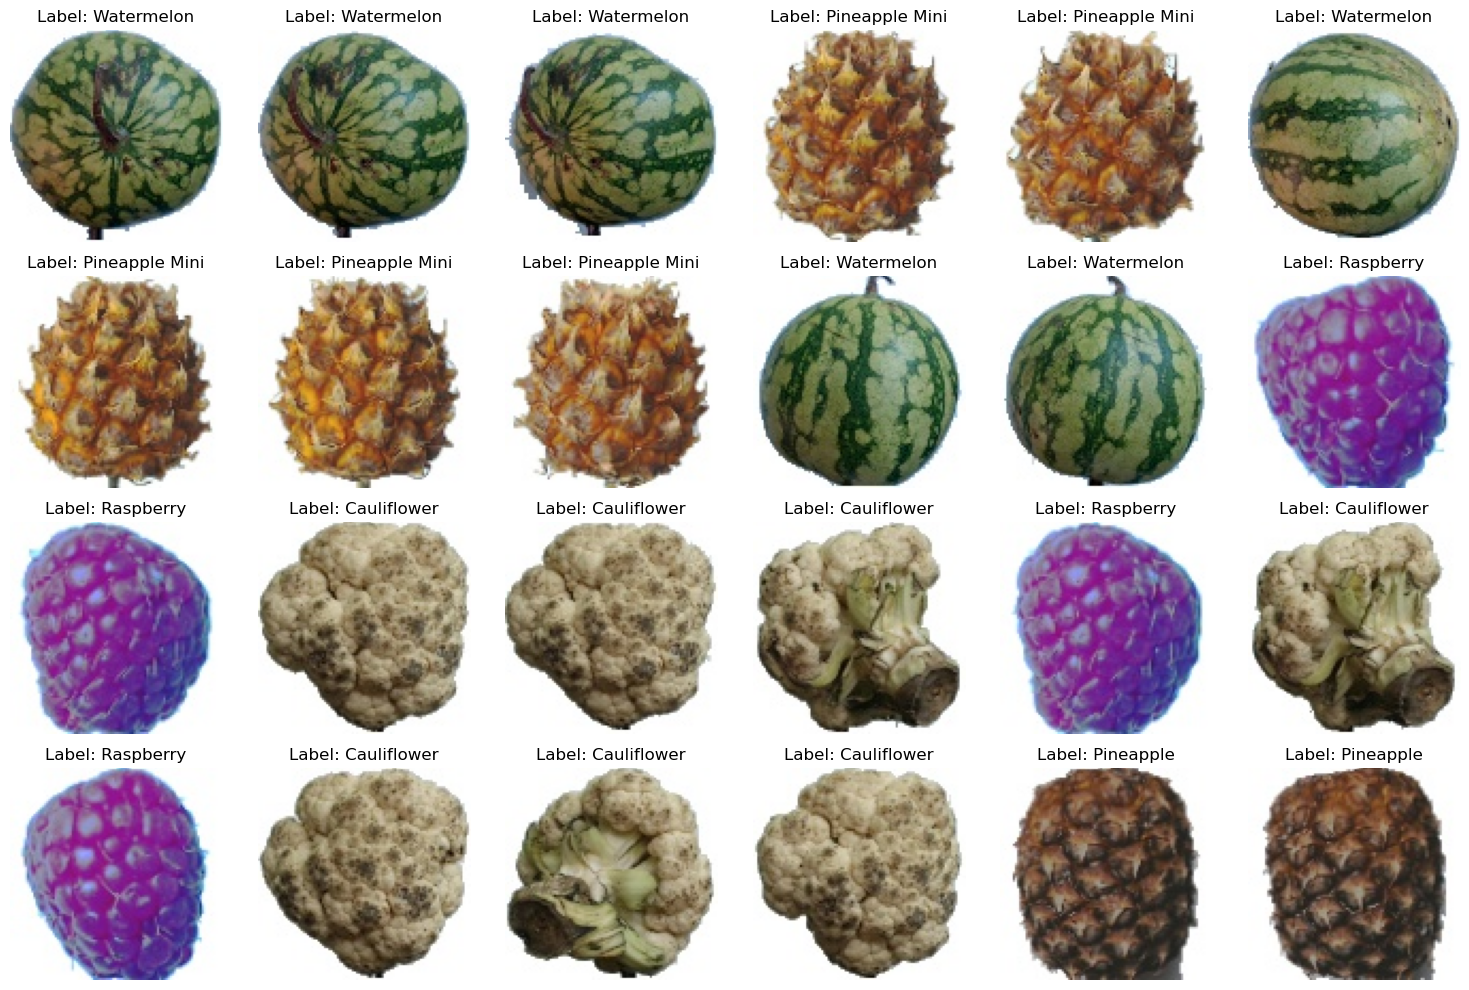

In [30]:
# Collecter les chemins et les étiquettes nécessaires
data = df_pca.select("path", "label").collect()

# Afficher les images avec matplotlib
fig, axes = plt.subplots(4, 6, figsize=(15, 10))
axes = axes.flatten()

for i, row in enumerate(data):
    if i >= 24:
        break
    try:
        # Ouvrir l'URL pour lecture et passer le résultat à Pillow
        with urllib.request.urlopen(row['path']) as url:
            img = np.array(Image.open(url))
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {row['label']}")
        axes[i].axis('off')
    except Exception as e:
        print(f"Erreur lors de la lecture de l'image à {row['path']}: {e}")

plt.tight_layout()
plt.show()